In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [3]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,   
    'model_name': "JAN_CNN05_2" # paste your telegram_id
}

tg_callback = TelegramCallback(config)

In [4]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [12]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")

lst = dfAll.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
train_ids = lst[-5:]
test_ids = lst[:-5]
print(train_ids, test_ids)

#df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
#df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids) & (dfAll.Version == "Normal")]

#df_test = df_test.reset_index()
#df_train = df_train.reset_index()

df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

[13  8 11 15  7] [ 1  2  9  6  4 14 17 16 12  3 10 18  5]


In [13]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [14]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: 0')

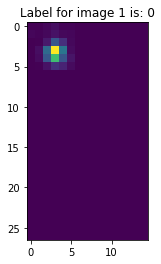

In [15]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [16]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.2

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [17]:
from keras import regularizers

In [ ]:

tf.get_default_graph()
########## HYPER PARAMETERS

batch_size = 100
epochs = 15000
optimizer = optimizers.Adam(lr=0.001)

l1v = 0.007
l2v = 0.014
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1), 
                 kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.40))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1v,l2v)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(Dropout(0.55))
model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(Dropout(0.55))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
current_name = "KnuckleFinger_Jan_v2_"
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/" + current_name + readable_timestamp


print(current_name + readable_timestamp)
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/"+ current_name + readable_timestamp + ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=100, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, learning_rate_reduction, tg_callback])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 27, 15, 128)       1280      
_________________________________________________________________
batch_normalization_5 (Batch (None, 27, 15, 128)       512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 15, 64)        73792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 15, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 8, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 8, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 8, 64)         36928     
__________

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()
plt.ylim(0.5,1)
plt.savefig("pres.jpg")

In [ ]:
print("end")

In [ ]:
# save model
model.save("CNN_25_02_19.h5")

In [ ]:
model.predict(x_train, batch_size=500, verbose=0)

In [ ]:
y_train_one_hot

In [ ]:
train_prediction=np.round(model.predict(x_train))
train_prediction=train_prediction.astype(int)

In [ ]:
val_prediction=np.round(model.predict(x_test))
val_prediction=val_prediction.astype(int)

In [ ]:
delta = val_prediction - y_test_one_hot
indices = []
for i in range(len(val_prediction)):
    if np.count_nonzero(delta[i]) > 0:
        indices += [i]

In [ ]:
len(indices)

In [ ]:
imagelist = []
for data_point in indices:
    print(data_point)
    plt.close()
    plt.clf()
    plt.cla()
    #plt.subplot(figsize=(6,6))
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    
    
    
    data_point = indices[0]
    data = df_train.Blobs.iloc[data_point]
    label = "Knuckle" if train_prediction[data_point][0] == 1 else "Finger"  
    ax.set_title("Input method: " + str(df_train.InputMethod.iloc[data_point]) + "\n" + "Label as: "  + label)
    #plt.imsave("PredictionImages/" + str(data_point)+".pdf", data, cmap='gray', vmin=0, vmax=255)
    plt.imsave("PredictionImages/{}.png".format(data_point), data, cmap="gray", vmin=0, vmax=255)
    #plt.close()


In [ ]:
from fpdf import FPDF

In [ ]:
incorrects